# Calibration Demo 

This notebook demonstrates micro image centroid localization as part of a plenoptic camera calibration based on **[PlenoptiCam](https://github.com/hahnec/plenopticam)**.

## Package and import prerequisites

In [1]:
import os, sys
print('Python v'+sys.version+'\n')

try:
    import plenopticam as pcam
except ImportError:
    !pip install plenopticam>=0.7.0
    import plenopticam as pcam
print('PlenoptiCam v'+pcam.__version__+'\n')

try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib --upgrade
    import matplotlib.pyplot as plt
    
%matplotlib inline

Python v3.7.7 (v3.7.7:d7c567b08f, Mar 10 2020, 02:56:16) 
[Clang 6.0 (clang-600.0.57)]

PlenoptiCam v0.7.0



## Image data acquisition
Available plenoptic photographs can be downloaded to the current folder ('./data') using the featured `DataDownloader` class, which is also used for extracting archived files.

In [2]:
loader = pcam.misc.DataDownloader()
loader.download_data(loader.opex_prep_url, fp='./data')
loader.extract_archive(archive_fn='./data/OpEx_data_prepared.zip')

Download skipped as OpEx_data_prepared.zip already exists


## Configuration of *PlenoptiCam*

Before running the process, configurations such as file paths need to be set, using the `PlenopticamConfig` class as follows

In [3]:
# instantiate config object and set image file paths and options
cfg = pcam.cfg.PlenopticamConfig()
cfg.default_values()
cfg.params[cfg.cal_path] = './data/f197with4m11pxf16Final.bmp'
cfg.params[cfg.opt_cali] = True
cfg.params[cfg.cal_meth] = pcam.cfg.constants.CALI_METH[0]

# instantiate status object to display processing progress
sta = pcam.misc.PlenopticamStatus()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/plenopticam-0.7.0-py3.7.egg/plenopticam/cfg/cfg.py:107: UserWarning: 

Grant permission to write to the config file /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/plenopticam-0.7.0-py3.7.egg/plenopticam/cfg/cfg.json
  warnings.warn('\n\nGrant permission to write to the config file '+fp, UserWarning)


## Reading a plenoptic photograph

Image files of the following extenions ('bmp', 'png', 'jpg', 'jpeg') can be loaded using the `load_img_file` procedure which is part of the featured `misc` module.

In [4]:
wht_img = pcam.misc.load_img_file(cfg.params[cfg.cal_path])

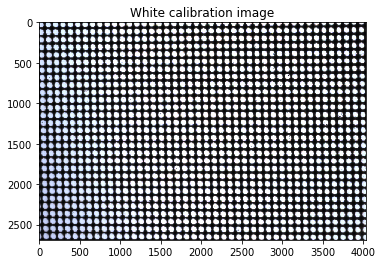

In [5]:
plt.figure()
plt.imshow(wht_img, cmap='gray', interpolation='none')
plt.grid(False)
plt.title('White calibration image')
plt.show()

Now the image data is read and stored in the `wht_img` variable.

## Micro image calibration

Once the white image is present, localization of micro image centroids $\mathbf{c}_{j,h}$ is conducted with the `LfpCalibrator` class at an abstract level. Results can be inspected in the plots below.

In [6]:
cal_obj = pcam.lfp_calibrator.LfpCalibrator(wht_img, cfg, sta)
ret = cal_obj.main()
cfg = cal_obj.cfg
del cal_obj


 Estimate micro image size
 Progress: Finished 


 Compute LoG
 Progress: Finished 


 Select maxima
 Progress: Finished 


 Refine micro image centers
 Progress: Finished 


 Sort micro image centers
 Progress: Finished 


 Save calibration data
 Progress: Finished 



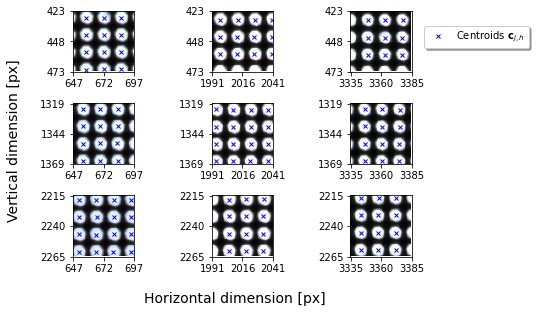

In [7]:
ret = cfg.load_cal_data()
y_coords = [row[0] for row in cfg.calibs[cfg.mic_list]]
x_coords = [row[1] for row in cfg.calibs[cfg.mic_list]]

s = 3
h, w, c = wht_img.shape if len(wht_img.shape) == 3 else wht_img.shape + (1,)
hp, wp = 50, 50
fig, axs = plt.subplots(s, s, facecolor='w', edgecolor='k')

for i in range(s):
    for j in range(s):
        # plot cropped image part
        k = i * (h // s) + (h // s) // 2 - hp // 2
        l = j * (w // s) + (w // s) // 2 - wp // 2
        axs[i, j].imshow(wht_img[k:k+hp, l:l+wp, ...], cmap='gray')

        # plot centroids in cropped area
        coords_crop = [(y, x) for y, x in zip(y_coords, x_coords) 
                       if k <= y <= k+hp-.5 and l <= x <= l+wp-.5]
        y_centroids = [row[0] - k for row in coords_crop]
        x_centroids = [row[1] - l for row in coords_crop]
        axs[i, j].plot(x_centroids, y_centroids, 'bx', 
                       markersize=4, label=r'Centroids $\mathbf{c}_{j,h}$')
        axs[i, j].grid(False)
        axs[i, j].tick_params(top=False, bottom=True, left=True, right=False,
                              labelleft=True, labelbottom=True)
        axs[i, j].set_yticks(range(0, hp+1, hp//2))
        axs[i, j].set_xticks(range(0, wp+1, wp//2))
        axs[i, j].set_yticklabels([str(k), str(k+hp//2), str(k+hp)])
        axs[i, j].set_xticklabels([str(l), str(l+wp//2), str(l+wp)])

# set common labels
fig.text(0.5, -0.05, 'Horizontal dimension [px]', ha='center', va='center', fontsize=14)
fig.text(-0.01, 0.5, 'Vertical dimension [px]', ha='center', va='center', rotation='vertical', fontsize=14)

fig.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(3, 3.85), fancybox=True, shadow=True)
plt.show()